# Model uncertainty based drift detection on CIFAR-10 and Wine-Quality datasets

### Method

Model-uncertainty drift detectors aim to directly detect drift that's likely to effect the performance of a model of interest. The approach is to test for change in the number of instances falling into regions of the input space on which the model is uncertain in its predictions. For each instance in the reference set the detector obtains the model's prediction and some associated notion of uncertainty. For example for a classifier this may be the entropy of the predicted label probabilities or for a regressor with dropout layers [dropout Monte Carlo](http://proceedings.mlr.press/v48/gal16.pdf) can be used to provide a notion of uncertainty. The same is done for the test set and if significant differences in uncertainty are detected (via a Kolmogorov-Smirnoff test) then drift is flagged. 

It is important that the detector uses a reference set that is disjoint from the model's training set (on which the model's confidence may be higher).


### Backend

For models that require batch evaluation both **PyTorch** and **TensorFlow** frameworks are supported. Alibi Detect does however not install PyTorch for you. 
Check the [PyTorch docs](https://pytorch.org/) how to do this.

### Classifier uncertainty based drift detection

We start by demonstrating how to leverage model uncertainty to detect malicious drift when the model of interest is a classifer.

#### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import torch
from torch import nn

from alibi_detect.cd import ClassifierUncertaintyDrift, RegressorUncertaintyDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
from alibi_detect.models.pytorch import trainer
from alibi_detect.cd.utils import encompass_batching

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the no-change null *H<sub>0</sub>*. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [7]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

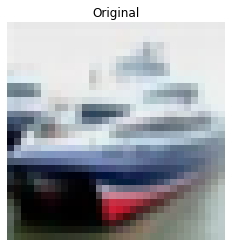

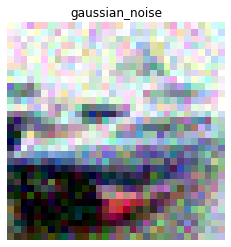

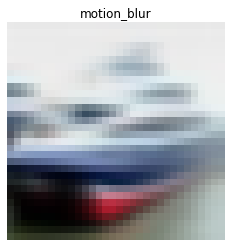

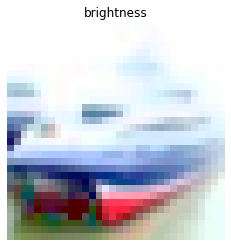

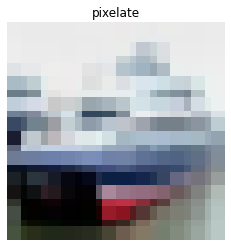

In [8]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [9]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


Given the drop in performance, it is important that we detect the harmful data drift!

#### Detect drift

Unlike many other approaches we needn't specify a dimension-reducing preprocessing step as the detector operates directly on the data as it is input to the model of interest. In fact, the two-stage projection  input -> prediction -> uncertainty can be thought of as the projection from the input space onto the real line, ready to perform the test.

We simply pass the model to the detector and inform it that the predictions should be interpreted as 'probs' rather than 'logits' (i.e. a softmax has already been applied). By default `uncertainty_type='entropy'` is used as the notion of uncertainty for classifier predictions, however `uncertainty_type='margin'` can be specified to deem the classifier's prediction uncertain if they fall within a margin (e.g. in \[0.45,0.55\] for binary classifier probabilities) (similar to [Sethi and Kantardzic (2017)](https://arxiv.org/abs/1704.00023)).

In [10]:
cd = ClassifierUncertaintyDrift(
  X_ref, model=clf, backend='tensorflow', p_val=0.05, preds_type='probs'
)

Let's check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

In [11]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print('Feature-wise p-values:')
            print(preds['data']['p_val'])
            print(f'Time (s) {dt:.3f}')

In [12]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
Feature-wise p-values:
[0.7868902]
Time (s) 15.574

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[0.]
Time (s) 33.066

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[0.]
Time (s) 32.637

Corruption type: brightness
Drift? No!
Feature-wise p-values:
[0.1102559]
Time (s) 34.126

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
[0.]
Time (s) 34.351


Note here how drift is only detected for the corrupted datasets on which the model's performance is significantly degraded. For the 'brightness' corruption, for which the model maintains 89% classification accuracy, the change in model uncertainty is not deemed significant (p-value 0.11, above the 0.05 threshold). For the other corruptions which signficiantly hamper model performance, the malicious drift is detected.

### Regressor uncertainty based drift detection

We now demonstrate how to leverage model uncertainty to detect malicious drift when the model of interest is a regressor. This is a less general approach as regressors often make point-predictions with no associated notion of uncertainty. However, if the model makes its predictions by ensembling the predicitons of sub-models then we can consider the variation in the sub-model predictions as a notion of uncertainty. `RegressorUncertaintyDetector` facilitates models that output a vector of such sub-model predictions (`uncertainty_type='ensemble'`) or deep learning models that include dropout layers and can therefore (as noted by [Gal and Ghahramani 2016](https://arxiv.org/abs/1506.02142)) be considered as an ensemble (`uncertainty_type='mc_dropout'`, the default option).

#### Dataset

The [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) consists of 1599 and 4898 samples of red and white wine respectively. Each sample has an associated quality (as determined by experts) and 11 numeric features indicating its acidity, density, pH etc. We consider the regression problem of tring to predict the quality of red wine sample given these features. We will then consider whether the model remains suitable for predicting the quality of white wine samples or whether the associated change in the underlying distribution should be considered as malicious drift.

First we load in the data.

In [13]:
red = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';'
)
white = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';'
)
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We can see that the data for both red and white wine samples take the same format.

In [14]:
white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


We shuffle and normalise the data such that each feature takes a value in \[0,1\], as does the quality we seek to predict.

In [15]:
red, white = np.asarray(red, np.float32), np.asarray(white, np.float32)
n_red, n_white = red.shape[0], white.shape[0]

col_maxes = red.max(axis=0)
red, white = red / col_maxes, white / col_maxes
red, white = red[np.random.permutation(n_red)], white[np.random.permutation(n_white)]
X, y = red[:, :-1], red[:, -1:]
X_corr, y_corr = white[:, :-1], white[:, -1:]

We split the red wine data into a set on which to train the model, a reference set with which to instantiate the detector and a set which the detector should not flag drift. We then instantiate a DataLoader to pass the training data to a PyTorch model in batches.

In [16]:
X_train, y_train = X[:(n_red//2)], y[:(n_red//2)]
X_ref, y_ref = X[(n_red//2):(3*n_red//4)], y[(n_red//2):(3*n_red//4)]
X_h0, y_h0 = X[(3*n_red//4):], y[(3*n_red//4):]

X_train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
X_train_dl = torch.utils.data.DataLoader(X_train_ds, batch_size=32, shuffle=True, drop_last=True)

#### Regression model

We now define the regression model that we'll train to predict the quality from the features. The exact details aren't important other than the presence of at least one dropout layer. We then train the model for 20 epochs to optimise the mean square error on the training data.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

reg = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, 1)
).to(device)

trainer(reg, nn.MSELoss(), X_train_dl, device, torch.optim.Adam, learning_rate=0.001, epochs=30)

/home/oliver/Projects/alibi-detect/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Epoch 30/30: 100%|██████████| 24/24 [00:00<00:00, 298.45it/s, loss=0.022]


We now evaluate the trained model on both unseen samples of red wine and white wine. We see that, unsurprisingly, the model is better able to predict the quality of unseen red wine samples.

In [18]:
reg = reg.eval()
reg_fn = encompass_batching(reg, backend='pytorch', batch_size=32)
preds_ref = reg_fn(X_ref)
preds_corr = reg_fn(X_corr)

ref_mse = np.square(preds_ref - y_ref).mean()
corr_mse = np.square(preds_corr - y_corr).mean()

print(f'MSE when predicting the quality of unseen red wine samples: {ref_mse}')
print(f'MSE when predicting the quality of unseen white wine samples: {corr_mse}')

MSE when predicting the quality of unseen red wine samples: 0.008570569567382336
MSE when predicting the quality of unseen white wine samples: 0.014613097533583641


#### Detect drift

We now look at whether a regressor-uncertainty detector would have picked up on this malicious drift. We instantiate the detector and obtain drift predictions on both the held-out red-wine samples and the white-wine samples. We specify `uncertainty_type='mc_dropout'` in this case, but alternatively we could have trained an ensemble model that for each instance outputs a vector of multiple independent predictions and specified `uncertainty_type='ensemble'`.

In [19]:
cd = RegressorUncertaintyDrift(
    X_ref, model=reg, backend='pytorch', p_val=0.05, uncertainty_type='mc_dropout', n_evals=100
)
preds_h0 = cd.predict(X_h0)
preds_h1 = cd.predict(X_corr)

print(f"Drift detected on unseen red wine samples? {'yes' if preds_h0['data']['is_drift']==1 else 'no'}")
print(f"Drift detected on white wine samples? {'yes' if preds_h1['data']['is_drift']==1 else 'no'}")

print(f"p-value on unseen red wine samples? {preds_h0['data']['p_val']}")
print(f"p-value on white wine samples? {preds_h1['data']['p_val']}")

Drift detected on unseen red wine samples? no
Drift detected on white wine samples? yes
p-value on unseen red wine samples? [0.23237702]
p-value on white wine samples? [1.7934791e-10]
